# PoC of Recommender System for safe and efficient Food Deliveries during Infectious Disease induced Lockdowns

Course "IBM Data Science", Capstone Project, April 2020 by [Markus Mächler](https://www.linkedin.com/in/markus-maechler/)

_written and tested with Jupyter Notebook (Anaconda3) on Win10x64 and MacOS_

**Folium maps are not rendered on github. For the best experience, please view the notebook [with this link](https://nbviewer.jupyter.org/github/Funisher-code/Coursera_Capstone/blob/master/notebook/POC_food_delivery_recommender_system.ipynb).**

----

## Introduction

### Major problems during a lockdown concerning shopping / food deliveries
1. keep people at risk **safe but not hungry**
2. keep shops and restaurants **up and running**
3. use helpers as **efficiently and safely** as possible

The purpose of this project is creating a small POC (proof of concept) to help tackling our three problems by creating a simple but efficient recommender system that could be used to place actual orders.

**For more background information, [read the report here](https://github.com/Funisher-code/Coursera_Capstone/blob/master/report/COVID-19_Safe_And_Efficient_Food_Deliveries.md).**

## Data

#### Location Data

For every order, **location data of all the three parties** is absolutely necessary. For this POC I'm using the following data sources.

- customers: **hypothetical address of a customer in Zurich**
- helpers: **hypothetical addresses in Zurich**
- shops: **Foursquare location data** acquired via API in the vicinity of people at risk


## Methodology

### install dependencies if not already installed

In [5]:
# map rendering library

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment if not installed already

In [6]:
# used to locate the coordinates of addresses, cities, countries, and landmarks across the globe
# using third-party geocoders and other data sources

#!conda install -c conda-forge geopy --yes # uncomment if not installed already

In [7]:
# install python library to generate fake data

#!conda install -c conda-forge faker --yes # uncomment if not installed already

### import necessary libraries

In [224]:
from geopy.geocoders import Nominatim
import geopy.distance
import folium 
import pandas as pd # for working with dataframes
import numpy as np # for workig with matrizes
from scipy import stats # for getting quick descriptive statistics
import matplotlib.pyplot as plt # for plotting
from  matplotlib.colors import LinearSegmentedColormap # to define custom colored maps in our plots
import requests # to handle requests
import time # let's python script sleep for a defined amount of time
from faker import Faker # to generate fake person data

print('Libraries imported.')

Libraries imported.


### get raw data

Let's define an address of a customer to work with. This would simply be something a customer would have to specify upon signing up.

In [3]:
custAddr = 'Gsteigstrasse 9, 8049 Zurich'

Now we define an instance of geocoder with user agent _food_explorer_.

And we use it to convert our customer address to a location in terms of latitude and longitude.

In [4]:
geolocator = Nominatim(user_agent="food_explorer")
location = geolocator.geocode(custAddr)
custLatitude = location.latitude
custLongitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(custAddr, custLatitude, custLongitude))

The geograpical coordinate of Gsteigstrasse 9, 8049 Zurich are 47.4028839, 8.499580847726023.


Let's quickly check if the coordinates reflect the addess of the customer.

In [20]:
# create map of Zurich using the latitude and longitude value generated by geocoder
map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=15)

# add marker of our address to the map
label = custAddr
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [custLatitude, custLongitude],
    radius=5,
    popup=label,
    color='red',
    parse_html=False).add_to(map_folium)  
    
map_folium

That certainly looks like Zurich but let's zoom all in to make sure it's accurate.

In [255]:
# create map of Zurich using the latitude and longitude value generated by geocoder
map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=18)

# add marker of our address to the map
label = custAddr
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [custLatitude, custLongitude],
    radius=10,
    popup=label,
    color='red',
    parse_html=False).add_to(map_folium)  
    
map_folium

Nice, that's something we can work with.

So customers signing up for the delivery service can simply specify their address as location data.

#### helper location data 

Just like with our customer we will use geolocator to convert our addresses to geolocations.

Unlike with the freshly signed up customer, we will import a list I created with __fictional helper data__ in the vicinity.

_TLDR alert, if you don't care how I got this data, leave the next session out [by clicking here to import the resulting csv](#division_ID)._
.

.

.

.

.

.

.

.

.

.

.

Or you can take the long way

.

.

.

.

.

.

**Thanks for staying with me. Here's what I did:**

1. query https://tel.search.ch/ for the postal code 8049
2. copy all search results from website that look something like this:
```
name01, surname01	
name01, surname01
street01 number01, 8049 Zürich
044 123 45 67
Details
name02, surname02	
name02, surname02
street02 number02, 8049 Zürich
044 765 43 21 *
Details
```
3. use some powerful editor: get rid of leading and trailing garbage, then convert to a usable csv format. I was on Win10 and used notepad++ for the following:
 - search for "\n" and replace with ";" since "," is already widely used
 - search for "\r" and "\t" and replace with nothing
 - search for ";Details;" and replace with "\n"


4. what we now have resembles something like this:
```
name01, surname01;name01, surname01;street01 number01, 8049 Zürich;044 123 45 67
name02, surname02;name02, surname02;street02 number02, 8049 Zürich;044 765 43 21 *
...
```

First we import the resulting file to a pandas dataframe.

```python
helperData=pd.read_csv('helperAddr_raw.csv', sep=';', header=None)
leads to the following error:
ParserError: Error tokenizing data. C error: Expected 4 fields in line 51, saw 5
```

That didn't work. What happened? After inspection of line 51 I realized that there are cases, where people also specify professions. Which then results in an additional column.
This is just another example why looking and curing your raw data is both important and time consuming.


For our purpose I'll just skip rows that don't match the number of columns.

In [7]:
helperData=pd.read_csv('helperAddr_raw.csv', sep=';', header=None, error_bad_lines=False)

b'Skipping line 4: expected 4 fields, saw 5\nSkipping line 5: expected 4 fields, saw 5\nSkipping line 8: expected 4 fields, saw 5\nSkipping line 10: expected 4 fields, saw 5\nSkipping line 11: expected 4 fields, saw 5\nSkipping line 12: expected 4 fields, saw 5\nSkipping line 14: expected 4 fields, saw 5\nSkipping line 16: expected 4 fields, saw 5\nSkipping line 17: expected 4 fields, saw 5\nSkipping line 21: expected 4 fields, saw 5\nSkipping line 23: expected 4 fields, saw 5\nSkipping line 27: expected 4 fields, saw 5\nSkipping line 28: expected 4 fields, saw 5\nSkipping line 33: expected 4 fields, saw 5\nSkipping line 39: expected 4 fields, saw 5\nSkipping line 41: expected 4 fields, saw 5\nSkipping line 42: expected 4 fields, saw 5\nSkipping line 43: expected 4 fields, saw 5\nSkipping line 44: expected 4 fields, saw 5\nSkipping line 46: expected 4 fields, saw 5\nSkipping line 48: expected 4 fields, saw 5\nSkipping line 50: expected 4 fields, saw 5\nSkipping line 53: expected 4 fiel

That's quite some skipped lines. Let's see how many addresses we got:

In [8]:
helperData.shape

(130, 4)

So after skipping quite some rows this resulted in 130 unique "fictional helpers".

By the way, the asterik after the phone number signifies, that the holder of the number doesn't want to get bothered by ad calls.

**Allthough this is all puplicly available information, let's get rid of all names and phone numbers.**

Then we name the remaining column address and have a look at the first 5 rows.

In [9]:
helperData.drop(columns=[0,1,3], inplace=True)
helperData.rename(columns={2:'address'}, inplace=True)
helperData.head()

,address
0,"Michelstrasse 6, 8049 Zürich"
1,"Riedhofstrasse 277, 8049 Zürich"
2,"Brunnwiesenstrasse. 78, 8049 Zürich"
3,"Rütihofstrasse 32, 8049 Zürich"
4,"Segantinistrasse 38, 8049 Zürich"


In [10]:
helperData.to_csv('helperData_addresses.csv',sep=';')

<a id = "division_ID"></a>
#### TLDR off

If you don't want to perform the manual steps up above you may join again from here.

Let's import the csv containing our addresses.

In [24]:
helperData=pd.read_csv('helperData_addresses.csv',sep=';')
helperData.drop(columns=['Unnamed: 0'], inplace=True)
helperData.head()

,address
0,"Michelstrasse 6, 8049 Zürich"
1,"Riedhofstrasse 277, 8049 Zürich"
2,"Brunnwiesenstrasse. 78, 8049 Zürich"
3,"Rütihofstrasse 32, 8049 Zürich"
4,"Segantinistrasse 38, 8049 Zürich"


In the next step, we us geolocator again to convert our helper addresses to locations.

I had to find out that too many requests in a short time leads to timeouts and the for loop to crash all the time.
But the following combination of try block and sleep function worked just fine: 

In [25]:
helpLat=[] # list to store latitutes
helpLong= [] # list to store longitudes
location=None # variable to check if geolocator returned a results
count=0 # counter for converted addresses 

print('starting geolocator conversion:')
for tmpAddr in helperData['address']:
    while(location is None): # try to use geolocator until a result is returned
        try: 
            location = geolocator.geocode(tmpAddr) # try converting address to gps position
            count+=1
            helpLat.append(location.latitude) # append latitude to list
            helpLong.append(location.longitude) # append longitude to list
            print('row',count,'converted:',tmpAddr,'to',location.latitude,',',location.longitude)
        except: # in case geocoder times out, wait half a second 
            #print('.',end='') # uncomment to see how many attempts failed
            time.sleep(0.5) #wait half a second
    location=None

starting geolocator conversion:
row 1 converted: Michelstrasse 6, 8049 Zürich to 47.4045882 , 8.4956993
row 2 converted: Riedhofstrasse 277, 8049 Zürich to 47.4068335 , 8.486364788336479
row 3 converted: Brunnwiesenstrasse. 78, 8049 Zürich to 47.401818899999995 , 8.502904109747357
row 4 converted: Rütihofstrasse 32, 8049 Zürich to 47.4139362 , 8.477824429475469
row 5 converted: Segantinistrasse 38, 8049 Zürich to 47.405278499999994 , 8.500653449999996
row 6 converted: Riedhofstrasse 63, 8049 Zürich to 47.4047016 , 8.492083950865386
row 7 converted: Riedhofstrasse 299, 8049 Zürich to 47.4077043 , 8.4850702
row 8 converted: Imbisbühlstrasse 17, 8049 Zürich to 47.403117 , 8.4936818
row 9 converted: Limmattalstrasse 266, 8049 Zürich to 47.4023642 , 8.4938806
row 10 converted: Im Wingert 12, 8049 Zürich to 47.4003858 , 8.509406051787845
row 11 converted: Kettberg 5, 8049 Zürich to 47.398512049999994 , 8.511144443967313
row 12 converted: Riedhofstrasse 29, 8049 Zürich to 47.40424195 , 8.4934

row 99 converted: Reinhold-Frei-Strasse 67, 8049 Zürich to 47.4105669 , 8.483620068895908
row 100 converted: Riedhofstrasse 41, 8049 Zürich to 47.4039369 , 8.4929601
row 101 converted: Rütihofstrasse 31, 8049 Zürich to 47.4135121 , 8.478689754897568
row 102 converted: Regensdorferstrasse 157, 8049 Zürich to 47.4034924 , 8.4973495
row 103 converted: Im oberen Boden 72, 8049 Zürich to 47.416623 , 8.481363723023257
row 104 converted: Segantinistrasse 63, 8049 Zürich to 47.4054201 , 8.498685540823669
row 105 converted: Rebbergstrasse 65, 8049 Zürich to 47.3977891 , 8.5115899
row 106 converted: Appenzellerstrasse 55, 8049 Zürich to 47.4006704 , 8.507789952394452
row 107 converted: Kappenbühlweg 11, 8049 Zürich to 47.40397745 , 8.498320080768725
row 108 converted: Heizenholz 45, 8049 Zürich to 47.411592299999995 , 8.485578726437662
row 109 converted: Frankentalerstrasse 35, 8049 Zürich to 47.40705455 , 8.479552765429101
row 110 converted: Bauherrenstrasse 48, 8049 Zürich to 47.40106799999999

In [26]:
print('Number of elements in the list helpLat: ',len(helpLat))
print('Number of elements in the list helpLong:',len(helpLong))

Number of elements in the list helpLat:  130
Number of elements in the list helpLong: 130


Seems to have worked.

Now let's add the 2 rows to our helper dataframe, name the columns and have a look at the resulting dataframe.

In [27]:
helperData['latitude']=helpLat
helperData['longitude']=helpLong
helperData.index.name='helperId'
helperData.head()

,address,latitude,longitude
helperId,,,
0,"Michelstrasse 6, 8049 Zürich",47.404588,8.495699
1,"Riedhofstrasse 277, 8049 Zürich",47.406833,8.486365
2,"Brunnwiesenstrasse. 78, 8049 Zürich",47.401819,8.502904
3,"Rütihofstrasse 32, 8049 Zürich",47.413936,8.477824
4,"Segantinistrasse 38, 8049 Zürich",47.405278,8.500653


In [28]:
helperData.tail()

,address,latitude,longitude
helperId,,,
125,"Riedhofweg 4, 8049 Zürich",47.408466,8.484372
126,"Kürbergstrasse 50, 8049 Zürich",47.398748,8.510023
127,"Riedhofstrasse 70, 8049 Zürich",47.405314,8.492104
128,"Winzerhalde 85, 8049 Zürich",47.402491,8.485379
129,"Gsteigstrasse 31, 8049 Zürich",47.403059,8.501921


Now we add some fake email addresses for our users.

In [29]:
# create a list of fake names and email addresses
fake = Faker(['de_DE']) 
helperEmail=[]
for i in range(len(helperData)):
    helperEmail.append(fake.email())

In [30]:
# check result
helperEmail[:5]

['henckgabriele@web.de',
 'louishaering@adler.org',
 'vera39@gmail.com',
 'trudi13@gmail.com',
 'bgeissler@butte.net']

In [31]:
# add fake email addresses to our dataframe
helperData['email']=helperEmail

Have a final look at our dataframe:

In [35]:
helperData.head()

,helperId,address,latitude,longitude,email
0,0,"Michelstrasse 6, 8049 Zürich",47.404588,8.495699,henckgabriele@web.de
1,1,"Riedhofstrasse 277, 8049 Zürich",47.406834,8.486365,louishaering@adler.org
2,2,"Brunnwiesenstrasse. 78, 8049 Zürich",47.401819,8.502904,vera39@gmail.com
3,3,"Rütihofstrasse 32, 8049 Zürich",47.413936,8.477824,trudi13@gmail.com
4,4,"Segantinistrasse 38, 8049 Zürich",47.405279,8.500653,bgeissler@butte.net


Looks good to me.

How about saving our work to a csv in case anything goes wrong:

In [33]:
helperData.to_csv('helperData.csv')

In [37]:
# helperData = pd.read_csv('helperData.csv') # uncomment in case you want to start from here

Now let's visualize the helpers and our customer on the map.

The customer is represented with a red circle and the possible helpers with blue circles.

In [38]:
# create map of Zurich using the latitude and longitude values generated by geocoder
map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=15)

# add a red cirle for the position of our customer to the map
label = custAddr
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [custLatitude, custLongitude],
    radius=10,
    popup=label,
    color='red',
    parse_html=False).add_to(map_folium)  

# add smaller blue circles for helpers
for email, lat, lng in zip(helperData['email'], helperData['latitude'], helperData['longitude']):    
    label = email
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#1234cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_folium)  

map_folium

#### shops - Foursquare location data

Right now we have a customer and possible helpers. But we still need positions of shops or restaurants where the helpers can fetch the goods and get them to the customer. 

For that will use realtime data we get by querying the Foursquare API.

First of all, we're gonna read the necessary Foursquare Credentials and Version **from the local File "cred_foursquare.json"**

this json could resemble something like the following structure:
```json
{
      "name": "Password JSON",
      "version": "1.0.0",
      "description": "",
      "command": "",
      "log": "",
      "location": "",
      "timeout": "0",
      "commandargs": "",
      "keys":
      [
         {
          "scriptkey": "VERSION",
          "scriptvalue": "20180605",
          "scriptdefaultvalue": ""
         },
   {
          "scriptkey": "ID",
          "scriptvalue": "***************************"
          "scriptdefaultvalue": ""
         },
   {
          "scriptkey": "SECRET",
          "scriptvalue": "***************************",
          "scriptdefaultvalue": "",
          "type": "password"
         }
      ]
}
```

The ID and SECRET can be obtained for free on https://developer.foursquare.com/ by registering for a free developer account.

After saving the credentials in the file "cred_foursquare.json" we can load the values into variables.

In [39]:
cred=pd.read_json(r'cred_foursquare.json')

In [40]:
VERSION=cred['keys'][0]['scriptvalue'] # Foursquare API version
CLIENT_ID=cred['keys'][1]['scriptvalue'] # Foursquare ID
CLIENT_SECRET=cred['keys'][2]['scriptvalue'] # Foursquare Secret
LIMIT=100 # max number of answers because number of queries on the free account are limited

Now let's think about __what type of venues__ we want to include as possible shops / restaurants 

Everybody can have a look at all of Foursquare's venue categories and the corresponding IDs that can be queried with the API:
https://developer.foursquare.com/docs/build-with-foursquare/categories/

__I'll go with the following in this case:__

Food
4d4b7105d754a06374d81259

Food & Drink Shop
4bf58dd8d48988d1f9941735

Fruit & Vegetable Store
52f2ab2ebcbc57f1066b8b1c

Market
50be8ee891d4fa8dcc7199a7

Pharmacy
4bf58dd8d48988d10f951735

Shopping Mall
4bf58dd8d48988d1fd941735


Of course there would also be a possibility to query for much more specific kinds of restaurants, e.g. a
Vegetarian / Vegan Restaurant
4bf58dd8d48988d1d3941735


To get going, we first __define a function that queries the Foursquare API and returns nearby venues__.

In [41]:
def getNearbyVenues(names, latitudes, longitudes, radius, categories): # function adapted from course script
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Searching venues for',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categories)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Customer Email', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now that we have the function in place, let's use it to get the venues that are close to our customer.

For the radius, let's just assume a reasonable number, e.g. 1 normal healthy young human walks at about 4 km/h by foot. So in 15 minutes the helper would travel 1 kilometer (=1000 meters). That's a reasonable number in a City like Zurich, where one has plenty of shopping possibilites. In rural areas one would probably consider cars as the transport way of choice and would also need to apply a larger radius.

For here, 1000 meters should be fine.

In [42]:
venues = getNearbyVenues(names=['hungrycustomer1942@bluewin.ch'],
                             latitudes=[custLatitude],
                             longitudes=[custLongitude],
                             radius=1000,
                             categories='4d4b7105d754a06374d81259,4bf58dd8d48988d1f9941735,52f2ab2ebcbc57f1066b8b1c,50be8ee891d4fa8dcc7199a7,4bf58dd8d48988d10f951735,4bf58dd8d48988d1fd941735'
                                  )
venues.shape

Searching venues for hungrycustomer1942@bluewin.ch


(12, 7)

So in our customers case we were able to find 12 venues nearby (in the radius of 1000 meters).

In [102]:
venues.head()

,Customer Email,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Kebab-Haus Höngg,47.402172,8.495997,Fast Food Restaurant
1,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Desperado,47.402083,8.496903,Mexican Restaurant
2,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Osteria da Biagio,47.402264,8.495558,Italian Restaurant
3,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Argentina Steakhouse,47.403935,8.496524,Steakhouse
4,hungrycustomer1942@bluewin.ch,47.402884,8.499581,Restaurant Turbinenhaus,47.395374,8.505774,Italian Restaurant


In [254]:
# create map of Zurich using the latitude and longitude values generated by geocoder
map_folium = folium.Map(location=[custLatitude, custLongitude], zoom_start=15)

# add a red cirle for the position of our customer to the map
label = custAddr
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [custLatitude, custLongitude],
    radius=10,
    popup=label,
    color='red',
    parse_html=False).add_to(map_folium)  


# add smaller blue circles for helpers
for email, lat, lng in zip(helperData['email'], helperData['latitude'], helperData['longitude']):    
    label = email
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#1234cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_folium)  
    
# add smaller green circles for helpers
for venue, lat, lng in zip(venues['Venue'], venues['Venue Latitude'], venues['Venue Longitude']):    
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#90ee90',
        fill_opacity=0.7,
        parse_html=False).add_to(map_folium)  

map_folium

Nice. As a human it would be quite obvious now to tell him to order at Marcello's Bistro and there are also quite a few ideal helpers because they live both near to the bistro and the customer.

However, our customer may not like the food Marcello's Bistro produces etc.

__So now here our recommender system comes into place.__

what we want to optimize:
- minimize total distance helper has to travel

assumptions:
- the position of our customer (C) is fixed.
- distances measured in air-line distance (may in some cases where street topology is special not lead to the ultimate best decisions, e.g. elevation ignored or dead end streets)

variables to measure distances the helper has to travel:
1. __HtoS__ = distance from the helper (H) to the shop (S)
2. __StoC__ = distance from shop (S) to customer (C)
3. __CtoH__ = distance from customer (C) to shop (S)

for the travel time of our helper to be minimized we need to minimze the sum of our variable 1 to 3 (HtoS+StoC+CtoH = __totDis__)

In [176]:
# initialize variables
numH = helperData.shape[0] # number of helpers
numS = venues.shape[0] # number of shops
numC = 1 # test with only 1 customer
HtoS = np.zeros([numS, numH]) # 2-dim matrix, helpers in columns, shops in rows
StoC = np.zeros([numS,1]) # 1-dim matrix, shops in rows
CtoH = np.zeros([1, numH]) # 1-dim matrix, helpers in columns
totDist = np.zeros([numS, numH]) #2-dim matrix, helpers in columns, shops in rows

In [228]:
# calculate distances from all helpers to all shops (in meters rounded to whole numbers)
for hId, helper in helperData.iterrows():
    for sId, shop in venues.iterrows():
        tmpCord1 = (helper['latitude'], helper['longitude'])
        tmpCord2 = (shop['Venue Latitude'], shop['Venue Longitude'])
        HtoS[sId][hId]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)

In [217]:
# calculate distances from all shops to our customer (in meters rounded to whole numbers)
tmpCord1 = (custLatitude, custLongitude)
for sId, shop in venues.iterrows():
    tmpCord2 = (shop['Venue Latitude'], shop['Venue Longitude'])
    StoC[sId][0]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)

In [219]:
# calculate distances from our customer to all helpers (in meters rounded to whole numbers)
tmpCord2 = (custLatitude, custLongitude)
for hId, helper in helperData.iterrows():
    tmpCord1 = (helper['latitude'], helper['longitude'])
    CtoH[0][hId]=round(geopy.distance.distance(tmpCord1, tmpCord2).m,0)   

Now we do some quick and dirty **heatmaps and descriptive statistics to get a feel for distribution of the distances** we have calculated here.

In [214]:
# define custom color map ranging from green to white to red 
greenToRed=LinearSegmentedColormap.from_list('gr',["g", "w","w","w","w","w", "r"], N=128)

The color range from green to red is separated by 5 segments of white to get a better feel for the extreme values.

Let's look at **distances between helpers and shops**:

In [229]:
 print(stats.describe(HtoS, axis=None))

DescribeResult(nobs=1560, minmax=(66.0, 2997.0), mean=1020.1467948717949, variance=347633.2350121708, skewness=0.6149120572489255, kurtosis=-0.05753935414874878)


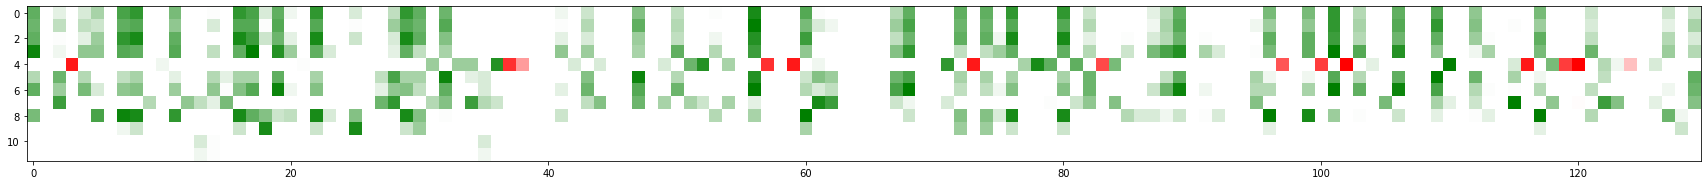

In [215]:
# Heatmap of distances from all helpers to all shops (green = closer, red = further away)
plt.figure(figsize = (30,30))
plt.imshow(HtoS, cmap=greenToRed)
plt.show()

The closest shop to a helper is only 66 meters away, mean distance is about 1 km and variance ist very high.

The shop with indice 4 seems to be close to only relatively few helpers.

Now we look at **distances between shops and customers**:

In [239]:
print(stats.describe(StoC,axis=None))

DescribeResult(nobs=12, minmax=(105.0, 957.0), mean=482.5833333333333, variance=99210.08333333334, skewness=0.3728582113979914, kurtosis=-1.475914078451692)


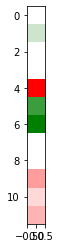

In [216]:
# Heatmap of distances from all shops to our customer (green = closer, red = further away)
plt.imshow(StoC, cmap=greenToRed)
plt.show()

We have a similar picture here. The shop with indice 4 also seems to be far away from our customer. It probably won't make it into our recommendation list, then.

**Shops 6,5 and 1 could be potentially interesting. Especially if items are heavy or refrigerated.**

And how to **distances between our customer and our helpers** look like:

In [241]:
print(stats.describe(CtoH,axis=None))

DescribeResult(nobs=130, minmax=(105.0, 2080.0), mean=876.6769230769231, variance=306164.14287418005, skewness=0.6655659563462873, kurtosis=-0.6208715228192303)


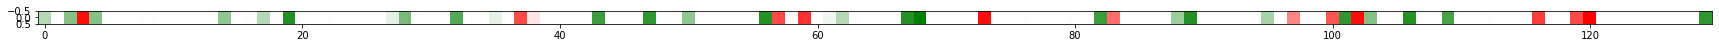

In [242]:
# Heatmap of distances from our customer to all helpers (green = closer, red = further away)
plt.figure(figsize = (30,30))
plt.imshow(CtoH, cmap=greenToRed)
plt.show()

There are quite a few helpers located close to our customer, which is promising.

Having our 3 matrices in place it is actually really simple now to **calculate our total distance:**

In [251]:
totDist=HtoS+StoC+CtoH

Again, we do simple descriptive statistics and a quick heatmap:

In [252]:
print(stats.describe(totDist,axis=None))

DescribeResult(nobs=1560, minmax=(281.0, 6034.0), mean=2379.4070512820513, variance=1379222.6392061806, skewness=0.5854207297337538, kurtosis=-0.23676402149009235)


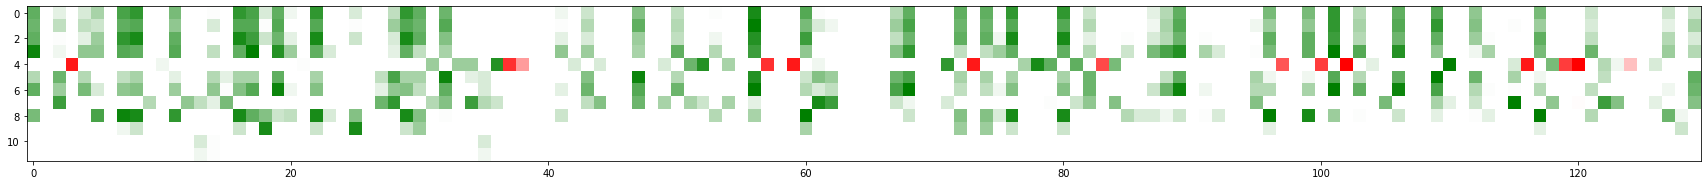

In [253]:
# Heatmap of total distances for all shop and helper combinations (green = closer, red = further away)
plt.figure(figsize = (30,30))
plt.imshow(HtoS, cmap=greenToRed)
plt.show()

### weighting

In [373]:
# function that returns a weight matrix depending on the weather, items purchased and equipment of the helper
def returnWeights (temperature, isRefrigerated=False, isHeavy=False, hasTrolley=False):
    
    # array structure 
    # for weights[HtoS, StoC, CtoH, totDist]
    w_standard = np.array([0, 2, 0, 5]) # total distance gets weighted 5 times and StoC 2 times more than other distances
    
    if temperature>30: # StoC gets weighted more the hotter it is
        w_refrigerated = np.array([0, 10, 0, 0])
    elif temperature>20:
        w_refrigerated = np.array([0, 6, 0, 0])
    elif temperature>10:
        w_refrigerated = np.array([0, 4, 0, 0])
    else:
        w_refrigerated = np.array([0, 2, 0, 0])

    if hasTrolley: # StoC gets weighted more for heavy items but even more so if the helper has no trolley
        w_heavy = np.array([0, 2, 0, 0])
    else:
        w_heavy = np.array([0, 5, 0, 0])
        
    w_total = w_standard + isRefrigerated*w_refrigerated + isHeavy*w_heavy

    # return normalized weight matrix where all weights sum up to 1
    w_total = w_total / w_total.sum()
    return w_total

In [313]:
np.array([1,2,3])+np.array([4,5,6])

array([5, 7, 9])

In [285]:
# read Openweathermap.org API credentials like in the example of the foursquare API
cred=pd.read_json(r'cred_openweathermap.json')

OWM_VERSION=cred['keys'][0]['scriptvalue'] # Openweathermap API version
OWM_APIKEY=cred['keys'][1]['scriptvalue'] # Openweathermap API key

In [289]:
def getWeatherData (lat, lon, APIKEY, VERSION):
    # create the API request URL
    url = 'https://api.openweathermap.org/data/{}/weather?lat={}&lon={}&appid={}&units=metric'.format(
        VERSION, 
        lat, 
        lon, 
        APIKEY)

    # make the GET request
    results = requests.get(url).json()
    
    return results

In [294]:
# call function to get weather
weather = getWeatherData(custLatitude, custLongitude, OWM_APIKEY, OWM_VERSION)
weather

{'coord': {'lon': 8.5, 'lat': 47.4},
 'weather': [{'id': 804,
   'main': 'Clouds',
   'description': 'overcast clouds',
   'icon': '04d'}],
 'base': 'stations',
 'main': {'temp': 16.31,
  'feels_like': 11.84,
  'temp_min': 13.33,
  'temp_max': 17.78,
  'pressure': 1009,
  'humidity': 45},
 'visibility': 10000,
 'wind': {'speed': 4.6, 'deg': 60},
 'clouds': {'all': 100},
 'dt': 1587406500,
 'sys': {'type': 1,
  'id': 6941,
  'country': 'CH',
  'sunrise': 1587356854,
  'sunset': 1587406902},
 'timezone': 7200,
 'id': 2658017,
 'name': 'Werdhölzli',
 'cod': 200}

This works fine, selected weather station makes sense and data seems to be reasonable for today.

Let's extract the maximum temperature for today.

In [302]:
# extract max temperature
tempMax = weather['main']['temp_max']
print(tempMax,'°C')

17.78 °C


Let's create a few test cases

In [399]:
print('Now we have a look at what weights are appliead when we alter our variables\n')

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)}) # print floats to only 4 digits precision

print(np.array(['HtoS', 'StoC', 'CtoH', 'totDis']))
standard_weights = returnWeights (tempMax, isRefrigerated=False, isHeavy=False, hasTrolley=False)
print(standard_weights,'-> standard case')

hT_weights = returnWeights (tempMax, isRefrigerated=False, isHeavy=True, hasTrolley=True)
print(hT_weights,'-> heavy items with trolley')

r_weights = returnWeights (tempMax, isRefrigerated=True, isHeavy=False, hasTrolley=False)
print(r_weights,'-> refrigerated items')

h_weights = returnWeights (tempMax, isRefrigerated=False, isHeavy=True, hasTrolley=False)
print(h_weights,'-> heavy items without trolley')

rhT_weights = returnWeights (tempMax, isRefrigerated=True, isHeavy=True, hasTrolley=True)
print(rhT_weights,'-> heavy refrigerated items with trolley')

rh_weights = returnWeights (tempMax, isRefrigerated=True, isHeavy=True, hasTrolley=False)
print(rh_weights,'-> heavy refrigerated items without trolley')

hot_rh_weights = returnWeights (temperature=35, isRefrigerated=True, isHeavy=True, hasTrolley=False)
print(hot_rh_weights,'-> heavy refrigerated items without trolley on a hot summers day')

Now we have a look at what weights are appliead when we alter our variables

['HtoS' 'StoC' 'CtoH' 'totDis']
[0.0000 0.2857 0.0000 0.7143] -> standard case
[0.0000 0.4444 0.0000 0.5556] -> heavy items with trolley
[0.0000 0.5455 0.0000 0.4545] -> refrigerated items
[0.0000 0.5833 0.0000 0.4167] -> heavy items without trolley
[0.0000 0.6154 0.0000 0.3846] -> heavy refrigerated items with trolley
[0.0000 0.6875 0.0000 0.3125] -> heavy refrigerated items without trolley
[0.0000 0.7727 0.0000 0.2273] -> heavy refrigerated items without trolley on a hot summers day


So in this setting total distance gets less weight and the distance from the shop to the customer gets more weight under certain conditions. Just like we wanted it to.

It's also obvious that HtoS and CtoH have no relevance at all in our current setting. So we might as well leave it out completely. But because future relevant use cases might bring importance to those as well, we keep it for now.